In [1]:
# import the necessary libraries

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Import, EDA and Pre-Processing

In [2]:
house_data = pd.read_csv("datasets/kc_house_data.csv")
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
incident_data = pd.read_csv("datasets/KCSO_Incident_Dataset__Historic_to_2019.csv")
incident_data.head()

,case_number,incident_datetime,incident_type,FCR,address_1,city,state,zip,created_at,updated_at,hour_of_day,day_of_week,Incident Block Location
0,C19046940,12/09/2019 09:02:00 AM,Other,503,1 Block AVE & YESLER WAY,SEATTLE,WA,98104,12/12/2019 06:19:00 PM,12/12/2019 08:07:00 PM,9,Monday,NaN
1,C19046039,12/02/2019 06:01:00 PM,Other,162,19700 Block 635TH PL NE,BARING,WA,98224,12/05/2019 05:15:00 PM,12/05/2019 07:06:00 PM,18,Monday,NaN
2,C19026684,07/14/2019 01:29:00 AM,Vehicle Recovery,311,1 Block PL S & DES MOINES MEMORIAL DR S,BURIEN,WA,98168,07/15/2019 05:45:00 AM,07/15/2019 06:09:00 PM,1,Sunday,NaN
3,C19043968,11/16/2019 10:07:00 PM,Traffic,404,RAINIER AVE N & RENTON AVE S,SKYWAY,WA,98178,11/19/2019 04:30:00 PM,11/19/2019 06:16:00 PM,22,Saturday,NaN
4,C19042199,11/04/2019 07:18:00 AM,Property Crime,313,1 Block PL S & DES MOINES MEMORIAL DR S,BURIEN,WA,98168,11/05/2019 04:35:00 PM,11/05/2019 06:26:00 PM,7,Monday,NaN


<AxesSubplot:>

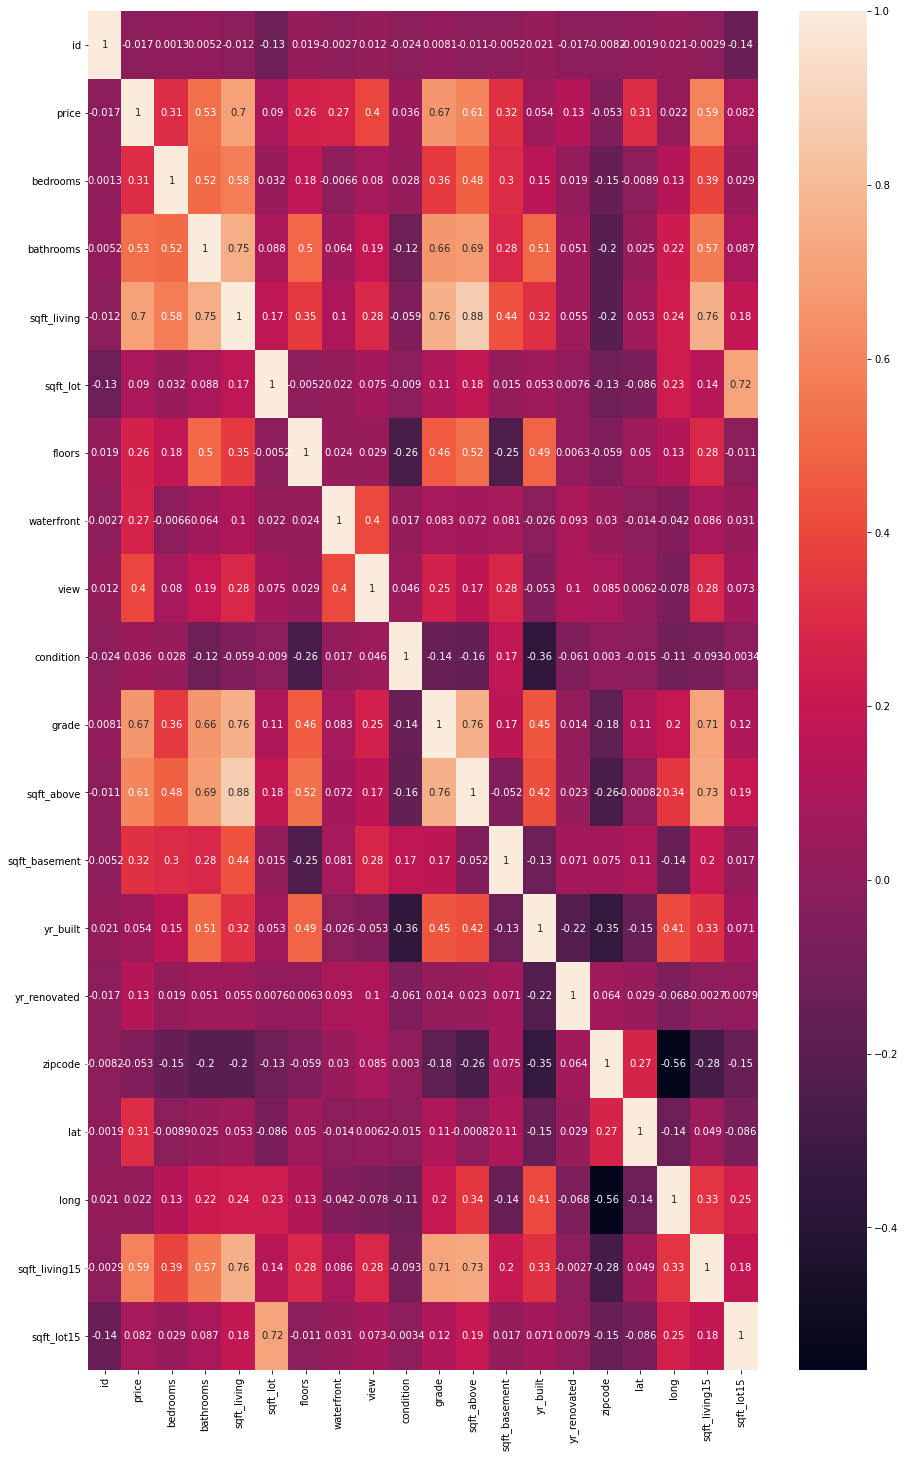

In [4]:
plt.figure(figsize=(15,25))
sns.heatmap(house_data.corr(), annot=True)

In [5]:
house_data.corr()["price"].sort_values(ascending=False)

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
id              -0.016762
zipcode         -0.053203
Name: price, dtype: float64

In [6]:
# convert those with yr_renovated == 0 to yr_built before dropping the yr_renovated column

house_data["new_yr_renovated"] = [house_data.iloc[i]["yr_renovated"].item() if house_data.iloc[i]["yr_renovated"].item() > 0 else house_data.iloc[i]["yr_built"].item() for i in range(len(house_data))]
house_data.drop(["yr_renovated"], axis=1, inplace=True)
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,new_yr_renovated
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,1955
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,1991
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,98028,47.7379,-122.233,2720,8062,1933
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,98136,47.5208,-122.393,1360,5000,1965
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,98074,47.6168,-122.045,1800,7503,1987


In [7]:
# filter and create a new df for crime incidences that occurred since 2000

filtered_incidences = []
for i in range(len(incident_data["incident_datetime"])):
    curr_datetime = incident_data["incident_datetime"][i]
    datetime_split = curr_datetime.split()
    curr_date = datetime.datetime.strptime(datetime_split[0], "%m/%d/%Y")
    if curr_date.year >= 2000 and curr_date.year <= 2015:
        curr_row = incident_data.iloc[i]
        temp = [curr_date.year, curr_row["zip"]]
        filtered_incidences.append(temp)
filtered_incidences_df = pd.DataFrame(filtered_incidences, columns=["year", "zip"])

In [8]:
def add_to_dict(dict_add, key):
    if key not in dict_add:
        dict_add[key] = 1
    else:
        dict_add[key] += 1

In [9]:
# create ref dict for cumulative crime numbers per year and zipcode

filtered_dict = {2014:{}, 2015:{}}
for i in range(len(filtered_incidences_df)):
    year, zip_code = filtered_incidences_df.iloc[i]["year"], filtered_incidences_df.iloc[i]["zip"]
    if not math.isnan(float(zip_code)):
        if year == 2015:
            add_to_dict(filtered_dict[2015], zip_code)
        else:
            add_to_dict(filtered_dict[2014], zip_code)
            add_to_dict(filtered_dict[2015], zip_code)
filtered_dict

{2014: {'89103': 1,
  '98077': 2,
  '98058': 5,
  '98038': 2,
  '98024': 3,
  '98118': 1,
  '98144': 1,
  '98045': 1,
  '98101': 1,
  '98146': 2,
  '98065': 1,
  '98001': 5,
  '98051': 1,
  '98019': 1,
  '98168': 1,
  '98059': 1,
  '98014': 1,
  '98105': 1,
  '98106': 1,
  '98022': 1,
  '98037': 1,
  '98074': 1,
  '98070': 2,
  '98104': 1,
  '98056': 1,
  '98023': 1},
 2015: {'89103': 1,
  '98077': 2,
  '98058': 6,
  '98038': 2,
  '98024': 3,
  '98042': 1,
  '98118': 1,
  '98144': 1,
  '98045': 1,
  '98101': 1,
  '98146': 2,
  '98065': 1,
  '98001': 5,
  '98051': 1,
  '98178': 2,
  '98019': 1,
  '98168': 1,
  '98072': 1,
  '98059': 2,
  '98105': 2,
  '98014': 1,
  '98106': 1,
  '98022': 1,
  '98037': 1,
  '98074': 1,
  '98070': 2,
  '98104': 1,
  '98053': 1,
  '98056': 1,
  '98023': 1}}

In [10]:
# create copy of house data for crime numbers to be included later

house_data_with_crime = house_data.copy()
house_data_with_crime.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,new_yr_renovated
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,1955
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,1991
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,98028,47.7379,-122.233,2720,8062,1933
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,98136,47.5208,-122.393,1360,5000,1965
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,98074,47.6168,-122.045,1800,7503,1987


In [11]:
# create column for no. of crimes for house data with crime numbers

crime_numbers = []
for i in range(len(house_data_with_crime)):
    date, zip_code = house_data_with_crime.iloc[i]["date"], str(house_data_with_crime.iloc[i]["zipcode"])
    date_split = date.split("T")
    curr_year = datetime.datetime.strptime(date_split[0], "%Y%m%d").year
    if zip_code not in filtered_dict[curr_year]:
        crime_numbers.append(0)
    else:
        crime_numbers.append(filtered_dict[curr_year][zip_code])
house_data_with_crime["no_of_crimes"] = crime_numbers

# can use below line to check if crime number corresponds to 98058 using ref dict (that was created earlier)
# house_data_with_crime[house_data_with_crime["zipcode"] == 98058]

In [12]:
# drop id and date for both dataframes as they do not provide much value
# (can consider implementing) however, first create columns for year, month & day before dropping date column

# house_data["date"] = pd.to_datetime(house_data["date"])
# house_data["year"] = house_data["date"].dt.year
# house_data["month"] = house_data["date"].dt.month
# house_data["day"] = house_data["date"].dt.day
# house_data_with_crime["date"] = pd.to_datetime(house_data_with_crime["date"])
# house_data_with_crime["year"] = house_data_with_crime["date"].dt.year
# house_data_with_crime["month"] = house_data_with_crime["date"].dt.month
# house_data_with_crime["day"] = house_data_with_crime["date"].dt.day
house_data.drop(["id", "date"], axis=1, inplace=True)
house_data_with_crime.drop(["id", "date"], axis=1, inplace=True)

In [13]:
house_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,new_yr_renovated
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,1955
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,1991
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,98028,47.7379,-122.233,2720,8062,1933
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,98136,47.5208,-122.393,1360,5000,1965
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,98074,47.6168,-122.045,1800,7503,1987


In [14]:
house_data_with_crime.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,new_yr_renovated,no_of_crimes
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,1955,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,1991,0
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,98028,47.7379,-122.233,2720,8062,1933,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,98136,47.5208,-122.393,1360,5000,1965,0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,98074,47.6168,-122.045,1800,7503,1987,1


# Train Test Split

**For house data w/o crime numbers**

In [15]:
X = house_data.iloc[:,1:].values
y = house_data.iloc[:,0].values

# can tune parameters accordingly for experimentation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=84)

**For house data with crime numbers**

In [16]:
X_2 = house_data_with_crime.iloc[:,1:].values
y_2 = house_data_with_crime.iloc[:,0].values

# can tune parameters accordingly for experimentation
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=84)

**Scaling features**

In [17]:
scaler = MinMaxScaler()

In [18]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)

# Linear Regression

In [20]:
regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)
train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")

Evaluation Metrics for LR
MAE: 123469.03643729379
MSE: 39956396716.22215
RMSE: 199890.9620673785
R-squared score for train: 0.693443122028099
Adjusted R-squared score for train: 0.6931875869811649
R-squared score for test: 0.7212355912542701
Adjusted R-squared score for test: 0.7210032230335873


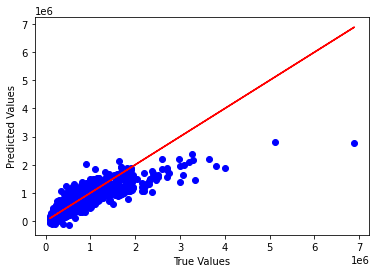

In [21]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

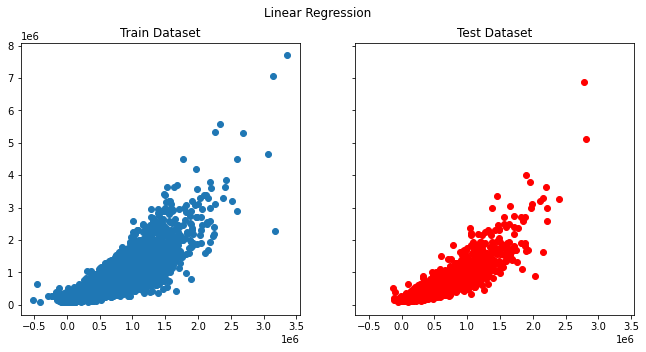

In [22]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [23]:
regression_with_crime = LinearRegression()
regression_with_crime.fit(X_train_2, y_train_2)
pred_with_crime = regression_with_crime.predict(X_test_2)
train_adjusted_r2 = 1 - (1-regression_with_crime.score(X_train_2, y_train_2)) * (len(y_2)-1)/(len(y_2)-X_2.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression_with_crime.score(X_test_2, y_test_2)) * (len(y_2)-1)/(len(y_2)-X_2.shape[1]-1)
print("Evaluation Metrics for LR (with crime)")
print(f"MAE: {mean_absolute_error(y_test_2, pred_with_crime)}")
print(f"MSE: {mean_squared_error(y_test_2, pred_with_crime)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_2, pred_with_crime))}")
print(f"R-squared score for train: {regression_with_crime.score(X_train_2, y_train_2)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression_with_crime.score(X_test_2, y_test_2)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")

Evaluation Metrics for LR (with crime)
MAE: 122822.26435132431
MSE: 39673090603.58849
RMSE: 199181.04981043877
R-squared score for train: 0.6953316445162784
Adjusted R-squared score for train: 0.6950635623250965
R-squared score for test: 0.723212137376366
Adjusted R-squared score for test: 0.7229685876431262


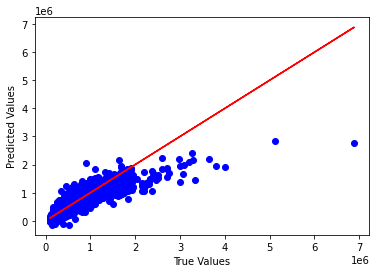

In [24]:
# For test set

# scatter for predictions
plt.scatter(y_test_2, pred_with_crime, color = "blue")
# perfect predictions
plt.plot(y_test_2, y_test_2, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

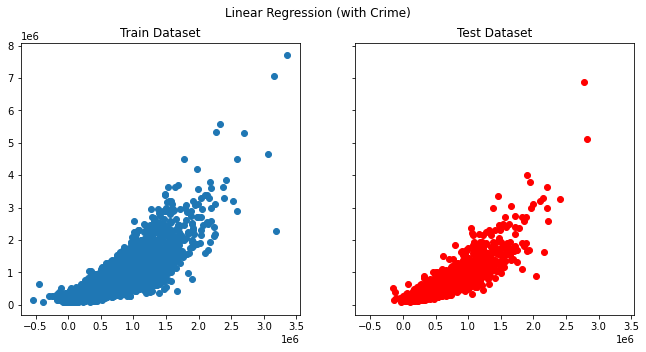

In [25]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression_with_crime.predict(X_train_2), y_train_2)
ax[1].scatter(pred_with_crime, y_test_2, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression (with Crime)')

plt.show()

# Lasso Regression

In [26]:
lasso = Lasso()
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
train_adjusted_r2 = 1 - (1-lasso.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-lasso.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Lasso")
print(f"MAE: {mean_absolute_error(y_test, lasso_pred)}")
print(f"MSE: {mean_squared_error(y_test, lasso_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, lasso_pred))}")
print(f"R-squared score for train: {lasso.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {lasso.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")

Evaluation Metrics for Lasso
MAE: 123488.0515451621
MSE: 39956242519.0862
RMSE: 199890.57636388513
R-squared score for train: 0.6934425509004254
Adjusted R-squared score for train: 0.6931870153774193
R-squared score for test: 0.7212366670438048
Adjusted R-squared score for test: 0.7210042997198625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15542302144831.562, tolerance: 229315126879.8434
  model = cd_fast.enet_coordinate_descent(


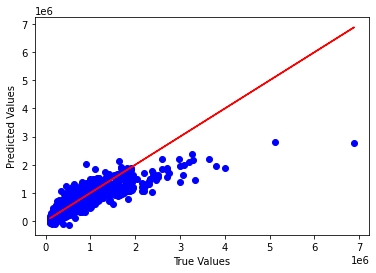

In [27]:
# For test set

# scatter for predictions
plt.scatter(y_test, lasso_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

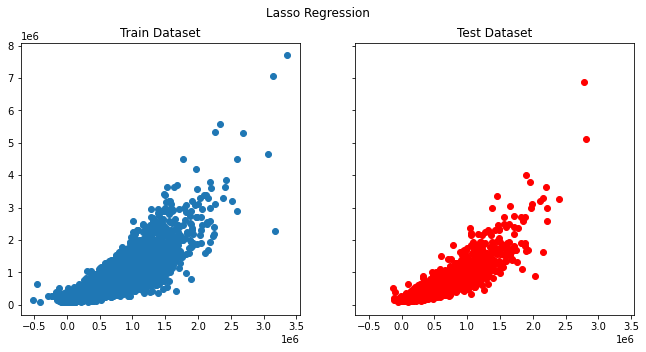

In [28]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(lasso.predict(X_train), y_train)
ax[1].scatter(lasso_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Lasso Regression')

plt.show()

In [29]:
lasso_crime = Lasso()
lasso_crime.fit(X_train_2, y_train_2)
lasso_pred_crime = lasso_crime.predict(X_test_2)
train_adjusted_r2 = 1 - (1-lasso_crime.score(X_train_2, y_train_2)) * (len(y_2)-1)/(len(y_2)-X_2.shape[1]-1)
test_adjusted_r2 = 1 - (1-lasso_crime.score(X_test_2, y_test_2)) * (len(y_2)-1)/(len(y_2)-X_2.shape[1]-1)
print("Evaluation Metrics for Lasso (with crime)")
print(f"MAE: {mean_absolute_error(y_test_2, lasso_pred_crime)}")
print(f"MSE: {mean_squared_error(y_test_2, lasso_pred_crime)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_2, lasso_pred_crime))}")
print(f"R-squared score for train: {lasso_crime.score(X_train_2, y_train_2)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {lasso_crime.score(X_test_2, y_test_2)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")

Evaluation Metrics for Lasso (with crime)
MAE: 122841.43411857435
MSE: 39672652636.34097
RMSE: 199179.95038743477
R-squared score for train: 0.6953307547928478
Adjusted R-squared score for train: 0.6950626718187851
R-squared score for test: 0.7232151929492113
Adjusted R-squared score for test: 0.7229716459046152


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15446939369316.062, tolerance: 229315126879.8434
  model = cd_fast.enet_coordinate_descent(


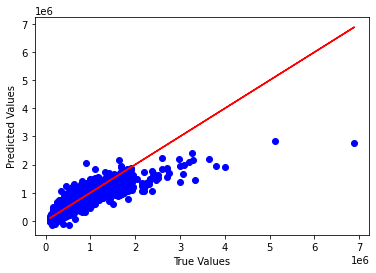

In [30]:
# For test set

# scatter for predictions
plt.scatter(y_test_2, lasso_pred_crime, color = "blue")
# perfect predictions
plt.plot(y_test_2, y_test_2, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

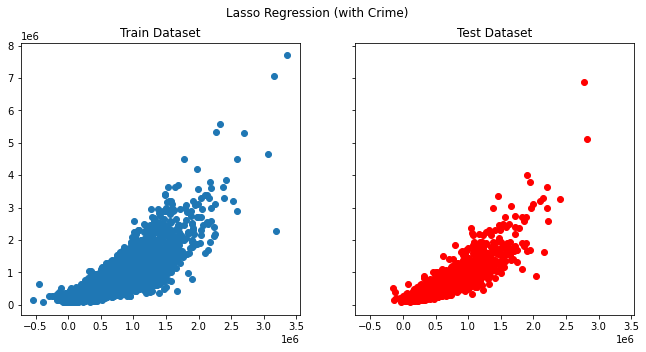

In [31]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(lasso_crime.predict(X_train_2), y_train_2)
ax[1].scatter(lasso_pred_crime, y_test_2, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Lasso Regression (with Crime)')

plt.show()

# XGBoost Regression

In [32]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
train_adjusted_r2 = 1 - (1-xgb.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-xgb.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"R-squared score for train: {xgb.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {xgb.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")

Evaluation Metrics for XGBoost
MAE: 68690.53122469928
MSE: 15002657257.332237
RMSE: 122485.33486639222
R-squared score for train: 0.9754481676596363
Adjusted R-squared score for train: 0.9754277021144789
R-squared score for test: 0.8953307299039532
Adjusted R-squared score for test: 0.8952434812764767


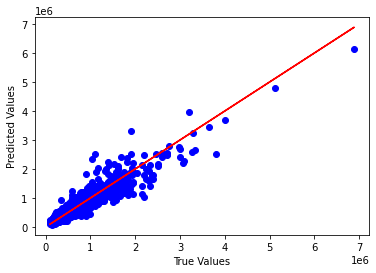

In [33]:
# For test set

# scatter for predictions
plt.scatter(y_test, xgb_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

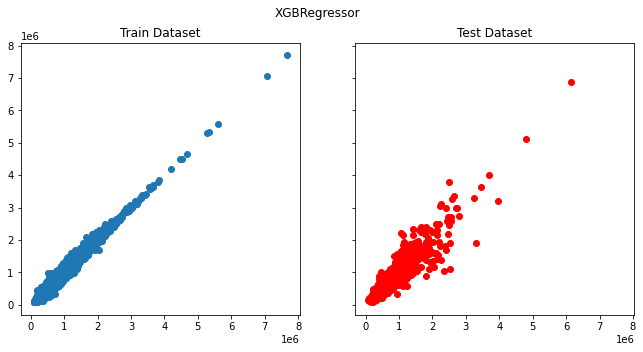

In [34]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(xgb.predict(X_train), y_train)
ax[1].scatter(xgb_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('XGBRegressor')

plt.show()

In [35]:
xgb_crime = XGBRegressor()
xgb_crime.fit(X_train_2, y_train_2)
xgb_pred_crime = xgb_crime.predict(X_test_2)
train_adjusted_r2 = 1 - (1-xgb_crime.score(X_train_2, y_train_2)) * (len(y_2)-1)/(len(y_2)-X_2.shape[1]-1)
test_adjusted_r2 = 1 - (1-xgb_crime.score(X_test_2, y_test_2)) * (len(y_2)-1)/(len(y_2)-X_2.shape[1]-1)
print("Evaluation Metrics for XGBoost (with crime)")
print(f"MAE: {mean_absolute_error(y_test_2, xgb_pred_crime)}")
print(f"MSE: {mean_squared_error(y_test_2, xgb_pred_crime)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_2, xgb_pred_crime))}")
print(f"R-squared score for train: {xgb_crime.score(X_train_2, y_train_2)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {xgb_crime.score(X_test_2, y_test_2)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")

Evaluation Metrics for XGBoost (with crime)
MAE: 67741.71059413312
MSE: 14478805745.462297
RMSE: 120327.9092540974
R-squared score for train: 0.9750897595740546
Adjusted R-squared score for train: 0.9750678406851512
R-squared score for test: 0.8989854928199918
Adjusted R-squared score for test: 0.8988966086614025


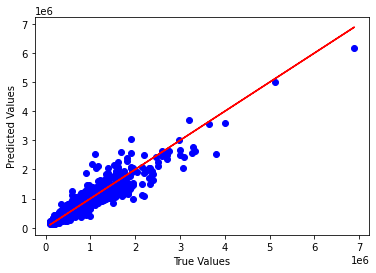

In [36]:
# For test set

# scatter for predictions
plt.scatter(y_test_2, xgb_pred_crime, color = "blue")
# perfect predictions
plt.plot(y_test_2, y_test_2, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

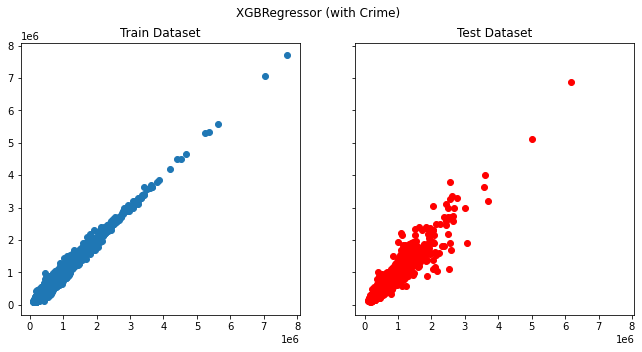

In [37]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(xgb_crime.predict(X_train_2), y_train_2)
ax[1].scatter(xgb_pred_crime, y_test_2, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('XGBRegressor (with Crime)')

plt.show()